In [1]:
import time
from tqdm import tqdm
from parse_LightGCN import parse_args
import torch
import os
from torch.utils.data import DataLoader
from ogb.linkproppred import Evaluator

from utils import *
from model import LightGCN
from dataprocess import General_dataset, load_data, normalize_edge_gcn
import math
from torch_sparse import SparseTensor

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"

/home/yu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser()

    # dataset
    parser.add_argument("--dataset", nargs="?", default="ogbl-collab")

    # model
    parser.add_argument("--model", type=str, default="GCN")
    parser.add_argument("--n_layers", type=int, default=1)
    parser.add_argument("--n_hidden", type=int, default=256)

    # training
    parser.add_argument('--epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=64 * 1024)
    parser.add_argument('--test_batch_size', type=int, default=1024)
    parser.add_argument('--num_workers', type=int, default=0)
    parser.add_argument('--pin_memory', type=int, default=0)
    parser.add_argument('--encoder_lr', type=float, default=1e-3)
    parser.add_argument('--predictor_lr', type=float, default=1e-2)
    parser.add_argument('--dropout', type=float, default=0.0)

    # specific for LP
    parser.add_argument("--n_neg", type=int, default=1, help="number of negative in K-pair loss")
    parser.add_argument('--topks', default=[5, 10, 20, 50, 100])

    # experiments
    parser.add_argument("--seed", type=int, default=1028,
                        help="seed to run the experiment")
    parser.add_argument("--early_stop", type=int, default=20,
                        help="early_stopping by which epoch*5")
    parser.add_argument("--eval_steps", type=int, default=1)
    parser.add_argument("--runs", type=int, default=5)
    parser.add_argument("--save", action = 'store_true')
    parser.add_argument("--train", action = 'store_true')
    parser.add_argument("--load", action = 'store_true')
    parser.add_argument('--model_name', type=str, default='gcn')

    parser.add_argument("--encoder_name", type=str, default='encoder')
    parser.add_argument("--predictor_name", type=str, default='predictor')

    parser.add_argument("--tc", type=str, default='tc')
    parser.add_argument("--tc_layer", type=int, default=1)

    parser.add_argument('--eval_node_type', type=str, default='Test')

    return parser.parse_args()


In [3]:
import sys
sys.argv = ['']
args = parse_args()
args

Namespace(batch_size=65536, dataset='ogbl-collab', dropout=0.0, early_stop=20, encoder_lr=0.001, encoder_name='encoder', epochs=1000, eval_node_type='Test', eval_steps=1, load=False, model='GCN', model_name='gcn', n_hidden=256, n_layers=1, n_neg=1, num_workers=0, pin_memory=0, predictor_lr=0.01, predictor_name='predictor', runs=5, save=False, seed=1028, tc='tc', tc_layer=1, test_batch_size=1024, topks=[5, 10, 20, 50, 100], train=False)

In [4]:
for _ in range(1):
    args = parse_args()

    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.path = os.getcwd()

    print(args)

    seed_everything(args.seed)

    """build dataset"""
    data, edge, adj_list_dict, neg_edge, test_node, eval_node, args.deg, args.tc, args.atc, args.density, args.n_nodes, args.n_edges = load_data(args)

    print('# of nodes:', args.n_nodes)
    print('# of edges:', args.n_edges)
    print('# of training edges:', edge['Train'].shape[0])
    print('# of validation edges:', edge['Val'].shape[0])
    print('# of testing edges:', edge['Test'].shape[0])
    print('Network density:', args.n_edges * 2 / (args.n_nodes * (args.n_nodes - 1)))
    
    for key in args.tc:
        print('TC-' + key, np.mean(np.array(args.tc[key])[test_node.numpy()]))

Namespace(batch_size=65536, dataset='ogbl-collab', device=device(type='cuda'), dropout=0.0, early_stop=20, encoder_lr=0.001, encoder_name='encoder', epochs=1000, eval_node_type='Test', eval_steps=1, load=False, model='GCN', model_name='gcn', n_hidden=256, n_layers=1, n_neg=1, num_workers=0, path='/home/yu/Dropbox/Project/ICLR-TC-analysis', pin_memory=0, predictor_lr=0.01, predictor_name='predictor', runs=5, save=False, seed=1028, tc='tc', tc_layer=1, test_batch_size=1024, topks=[5, 10, 20, 50, 100], train=False)
# of nodes: 235868
# of edges: 1074045
# of training edges: 967632
# of validation edges: 60084
# of testing edges: 46329
Network density: 3.8611463715130124e-05
TC-train_train 0.49777879645063955
TC-train_val 0.1355711694069623
TC-train_test 0.21655367572820286


In [8]:
import pickle as pkl
score = pkl.load(open('./res/ogbl-collab/LightGCN/0_score.pkl', 'rb'))

In [9]:
score_train = np.stack([_['Train'] for _ in score])
score_val = np.stack([_['Val'] for _ in score])
score_test = np.stack([_['Test'] for _ in score])

In [14]:
train_train_tc = np.array(args.tc['train_train'])
train_test_tc = np.array(args.tc['train_test'])

/tmp/ipykernel_2134639/658612080.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'./fig/{args.dataset}/Embedding Similarity as Epochs.png', transparency = True, dpi = 200, bbox_inches = 'tight')


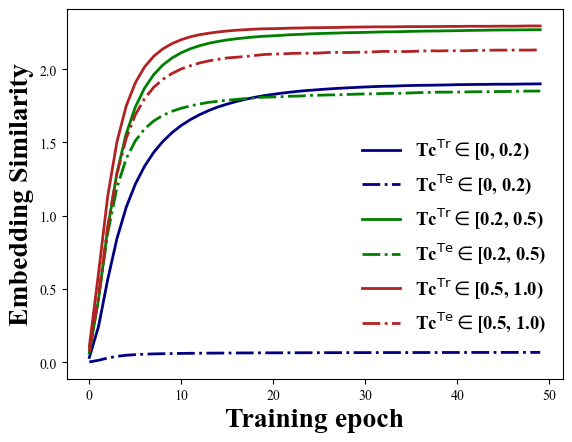

In [15]:
import numpy as np
import matplotlib.pyplot as plt

intervals = [(0, 0.2), (0.2, 0.5), (0.5, 1.0)]
colors = ['navy', 'green', 'firebrick']

x = np.arange(score_train.shape[0])

for (low, high), color in zip(intervals, colors):
    mask = (train_train_tc >= low) & (train_train_tc < high)
    mean_score = score_train[:, mask].mean(axis=1)
    plt.plot(x, mean_score, label="Tc$^{\mathrm{Tr}}\in$" + f"[{low}, {high})", color=color, linestyle = '-', linewidth = 2)

    mask = (train_test_tc >= low) & (train_test_tc < high)
    mean_score = score_test[:, mask].mean(axis=1)
    plt.plot(x, mean_score, label="Tc$^{\mathrm{Te}}\in$" + f"[{low}, {high})", color=color, linestyle = '-.', linewidth = 2)

plt.xlabel('Training epoch', fontsize=20, fontweight='bold')
plt.ylabel('Embedding Similarity', fontsize=20, fontweight='bold')
plt.legend(fontsize=13.5, frameon=False, bbox_to_anchor=(1.0, 0.7), prop = {'size': 13.5, 'weight': 'bold'})
plt.savefig(f'./fig/{args.dataset}/Embedding Similarity as Epochs.png', transparency = True, dpi = 200, bbox_inches = 'tight')

In [15]:
def group_by_deg_lcc(val, deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    vall, count = np.zeros((5, deg_group_num)), np.zeros((5, deg_group_num))
    
    for r, d, l in zip(val, deg, lcc):
        if d < threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval)

            vall[idx, idx3] += r
            count[idx, idx3] += 1
            
    vall = vall/count
    
    return vall

def ratio_group_by_deg_lcc(deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    count = np.zeros((5, deg_group_num))
    
    for d, l in zip(deg, lcc):
        if d <= threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval) - 1

            count[idx, idx3] += 1
    
#     count /= len(deg)
    
    return count

def ratio_group_by_deg_lcc2(deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    count = np.zeros((5, deg_group_num))
    
    for d, l in zip(deg, lcc):
        if d <= threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval)

            count[idx, idx3] += 1
    
#     count /= len(deg)
    
    return count

def group_by_tc_dist(val, tc):
    vall, count = np.zeros((5, val.shape[0])), np.zeros(5)
    
    for i in range(val.shape[1]):
        idx = int(tc[i]/0.4) + 2
        
        vall[idx] += val[:, i]
        count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)

In [16]:
split = 'Val'

val_recalls, val_ndcgs, val_hits, val_f1s, val_precisions, val_scores, val_mrrs = [], [], [], [], [], [], []
for run in range(args.runs):
    val_recalls.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_recall_list_' + split + '.npy'))
    val_ndcgs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_ndcg_list_' + split + '.npy'))
    val_hits.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_hit_ratio_list_' + split + '.npy'))
    val_f1s.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_F1_list_' + split + '.npy'))
    val_precisions.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_precision_list_' + split + '.npy'))
    val_mrrs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_mrr_list_' + split + '.npy'))


val_recalls = np.stack(val_recalls, axis = 0)
val_ndcgs = np.stack(val_ndcgs, axis = 0)
val_hits = np.stack(val_hits, axis = 0)
val_f1s = np.stack(val_f1s, axis = 0)
val_precisions = np.stack(val_precisions, axis = 0)
val_mrrs = np.stack(val_mrrs, axis = 0)

#MEAN: x.mean(axis = 1).mean(axis = 0)
#STD: x.mean(axis = 1).std(axis = 0)

val_metrics = [val_precisions, val_f1s, val_ndcgs, val_recalls, val_mrrs, val_hits]

In [17]:
keys = ['Precision', 'F1', 'NDCG', 'Recall',  'MRR', r'Hits$^N$']

In [18]:
split = 'Test'

test_recalls, test_ndcgs, test_hits, test_f1s, test_precisions, test_mrrs = [], [], [], [], [], []
for run in range(args.runs):
    test_recalls.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_recall_list_' + split + '.npy'))
    test_ndcgs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_ndcg_list_' + split + '.npy'))
    test_hits.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_hit_ratio_list_' + split + '.npy'))
    test_f1s.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_F1_list_' + split + '.npy'))
    test_precisions.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_precision_list_' + split + '.npy'))
    test_mrrs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_mrr_list_' + split + '.npy'))


test_recalls = np.stack(test_recalls, axis = 0)
test_ndcgs = np.stack(test_ndcgs, axis = 0)
test_hits = np.stack(test_hits, axis = 0)
test_f1s = np.stack(test_f1s, axis = 0)
test_precisions = np.stack(test_precisions, axis = 0)
test_mrrs = np.stack(test_mrrs, axis = 0)

#MEAN: x.mean(axis = 1).mean(axis = 0)
#STD: x.mean(axis = 1).std(axis = 0)

test_metrics = [test_precisions, test_f1s, test_ndcgs, test_recalls, test_mrrs, test_hits]

In [19]:
for key, metric in zip(keys, val_metrics):
    print(key, metric.mean(axis = 1).mean(axis = 0), metric.mean(axis = 1).std(axis = 0))

Precision [0.1296 0.1    0.0678 0.036  0.0213] [0.0037 0.0021 0.0014 0.0009 0.0004]
F1 [0.1373 0.1319 0.1036 0.062  0.0387] [0.0033 0.0024 0.0016 0.0011 0.0006]
NDCG [0.1838 0.2155 0.242  0.2671 0.2809] [0.0062 0.0059 0.0056 0.0054 0.0051]
Recall [0.1934 0.2822 0.3587 0.4398 0.4929] [0.0048 0.0055 0.0052 0.0057 0.0048]
MRR 0.2775560782804486 0.009706147980158475
Hits$^N$ [0.4234 0.5416 0.6313 0.7148 0.7605] [0.0116 0.01   0.0066 0.0055 0.0036]


In [21]:
for key, metric in zip(keys, test_metrics):
    print(key, metric.mean(axis = 1).mean(axis = 0), metric.mean(axis = 1).std(axis = 0))

Precision [0.0903 0.0697 0.0475 0.0255 0.0153] [0.0027 0.0016 0.0008 0.0004 0.0002]
F1 [0.1009 0.0959 0.0749 0.0451 0.0285] [0.0028 0.002  0.0011 0.0005 0.0003]
NDCG [0.1368 0.1633 0.1854 0.2065 0.2191] [0.0051 0.0048 0.0045 0.0042 0.004 ]
Recall [0.1545 0.2275 0.292  0.3629 0.4129] [0.0044 0.0047 0.0046 0.0035 0.0031]
MRR 0.2122336282571755 0.0070070705975628055
Hits$^N$ [0.3343 0.4464 0.5363 0.6251 0.6778] [0.0088 0.0077 0.0052 0.004  0.0025]


In [22]:
train_deg = np.array(args.deg['Train'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]

tc_val_node = {'train': np.array(args.tc['train_train'])[eval_node['Val']], \
               'val': np.array(args.tc['train_val'])[eval_node['Val']],\
               'test': np.array(args.tc['train_test'])[eval_node['Val']]}

tc_test_node = {'train': np.array(args.tc['train_train'])[eval_node['Test']], \
                'val': np.array(args.tc['train_val'])[eval_node['Test']],\
                'test': np.array(args.tc['train_test'])[eval_node['Test']]}

In [23]:
density = np.array(args.density)[test_node]

## Perform post analysis
### 1. Degree vs Performance
#### 1.1 Degree vs Val Performance (Cold and Non-Cold)
#### 1.2 Degree vs Test Performance (Cold and Non-Cold)

### 2. TC vs Performance
#### 2.1 Train-TC vs Val Performance (Cold and Non-Cold)
#### 2.2 Train-TC vs Test Performance (Cold and Non-Cold)
#### 2.3 Val-TC vs Val Performance (Cold and Non-Cold)
#### 2.4 Va-TC vs Test Performance (Cold and Non-Cold)

### 3. Degree vs TC
#### 3.1. Train-TC vs Degree (Cold and Non-Cold)
#### 3.2. Val-TC vs Degree (Cold and Non-Cold)

In [135]:
def group_by_deg(val, deg, deg_group_num, interval, threshold):
    vall, count = np.zeros((deg_group_num, val.shape[0])), np.zeros(deg_group_num)
    
    for i in range(val.shape[1]):
        d = deg[i]
        
        if d < threshold:
            idx = min(int(d//interval), deg_group_num - 1)

            vall[idx] += val[:, i]
plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)


def group_by_deg_log(val, deg, threshold, base):
    deg2 = deg
    deg2[deg2 == 0] = 1
    log_deg2 = np.emath.logn(base, deg2).astype(int)
    
    log_threshold = np.emath.logn(base, np.array(threshold)).astype(int)

    unique_log_deg2 = np.unique(log_deg2)
    log_deg2 -= unique_log_deg2[0]
    
    group_num = (unique_log_deg2 < log_threshold).sum().item()
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    for i in range(val.shape[1]):
        d = log_deg2[i]
        
        if d < log_threshold - unique_log_deg2[0]:
            idx = d

            vall[idx] += val[:, i]
            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1), np.unique(log_deg2[log_deg2 < log_threshold])


def group_by_tc(val, tc, group_num, interval, threshold):
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    for i in range(val.shape[1]):
        if tc[i] <= threshold:
            # idx = int(tc[i]//interval)
            idx = min(int(tc[i]//interval), group_num - 1)

            vall[idx] += val[:, i]
            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)

def group_by_tc_log(val, tc, threshold, base):
    tc2 = tc
    tc2[tc2 == 0] = min(tc[tc != 0])
    log_tc2 = np.emath.logn(base, tc2).astype(int)
    
    
    log_threshold = np.emath.logn(base, np.array(threshold)).astype(int)

    unique_log_tc2 = np.unique(log_tc2)
    log_tc2 -= unique_log_tc2[0]
    
    group_num = (unique_log_tc2 < log_threshold).sum().item()
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    
    for i in range(val.shape[1]):
        d = log_tc2[i]
        
        if d < log_threshold - unique_log_tc2[0]:
            idx = d

            vall[idx] += val[:, i]
            count[idx] += 1
          
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1), np.unique(log_tc2[log_tc2 < log_threshold])

In [421]:
class analysis(object):
    def __init__(self, tc_val_node, tc_test_node):
        self.tc_val_node = tc_val_node
        self.tc_test_node = tc_test_node
    
    def deg_perform(self, keys, metrics, deg, xticklabels, args, group_num, interval, upper_limit, file_name, xlabel):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v = group_by_deg(metric[:, :, 1], deg, group_num, interval, upper_limit)
            else:
                title = key
                mean_v, std_v = group_by_deg(metric, deg, group_num, interval, upper_limit)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel(xlabel, fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        # ax.set_title('Collab', fontsize = 20, fontweight = 'bold')
        # ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
    

    def deg_perform_line(self, keys, metrics, deg, xticklabels, args, group_num, interval, upper_limit, file_name, xlabel):
        mean_vs, std_vs, labels = [], [], []
    
        for key, metric in zip(keys, metrics):
            labels.append(key)
    
            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v = group_by_deg(metric[:, :, 1], deg, group_num, interval, upper_limit)
            else:
                title = key
                mean_v, std_v = group_by_deg(metric, deg, group_num, interval, upper_limit)
    
            mean_vs.append(mean_v)
            std_vs.append(std_v)
    
        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)
    
        # Create an array with the positions of the data points along the x-axis
        num_groups, num_lines_per_group = mean_vs.shape
        x = np.arange(num_groups)
    
        # Create the line chart with error bars and shaded region
        fig, ax = plt.subplots(figsize=(15, 5))
    
        for i in range(num_lines_per_group):
            ax.plot(x, mean_vs[:, i], marker='o', linestyle='-', label=labels[i])
            ax.fill_between(x, mean_vs[:, i] - std_vs[:, i], mean_vs[:, i] + std_vs[:, i], alpha=0.2)  # Shaded region
    
        # Customize the plot
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels, fontsize=15)
        ax.tick_params('y', labelsize=15)
        ax.set_xlabel(xlabel, fontsize=20, fontweight='bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize=20, fontweight='bold')
        # ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon=0)
        # ax.set_title('Collab', fontsize = 20, fontweight = 'bold')
    
        # Save the plot
        plt.savefig(file_name, transparent=True, dpi=200, bbox_inches='tight')


    
    def log_deg_perform(self, keys, metrics, deg, xticklabels, args, upper_limit, base, file_name):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v, unique_val = group_by_deg_log(metric[:, :, 1], deg, upper_limit, base)
            else:
                title = key
                mean_v, std_v, unique_val = group_by_deg_log(metric, deg, upper_limit, base)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)

        # print(mean_vs.shape, std_vs.shape)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # num_groups, num_bars_per_group = mean_vs.shape
        # xticklabels = all_xticklabels[:num_groups]
        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel('Train-Degree Group', fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
        
        return unique_val
    
    def tc_perform(self, keys, metrics, tc, xticklabels, args, group_num, interval, upper_limit, file_name, xlabel):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v = group_by_tc(metric[:, :, 1], tc, group_num, interval, upper_limit)
            else:
                title = key
                mean_v, std_v = group_by_tc(metric, tc, group_num, interval, upper_limit)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel(xlabel, fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        # ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=len(labels), frameon = 0, prop={'size': 20, 'weight':'bold'})
        # ax.set_title('Collab', fontsize = 20, fontweight = 'bold')

        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
                            
    def log_tc_perform(self, keys, metrics, tc, xticklabels, args, upper_limit, base, file_name):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v, unique_val = group_by_tc_log(metric[:, :, 1], tc, upper_limit, base)
            else:
                title = key
                mean_v, std_v, unique_val = group_by_tc_log(metric, tc, upper_limit, base)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)

        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel('Train-TC Group', fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
        
        return unique_val

In [422]:
analyzer = analysis(tc_val_node, tc_test_node)

In [138]:
train_deg.max()

382

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (9).

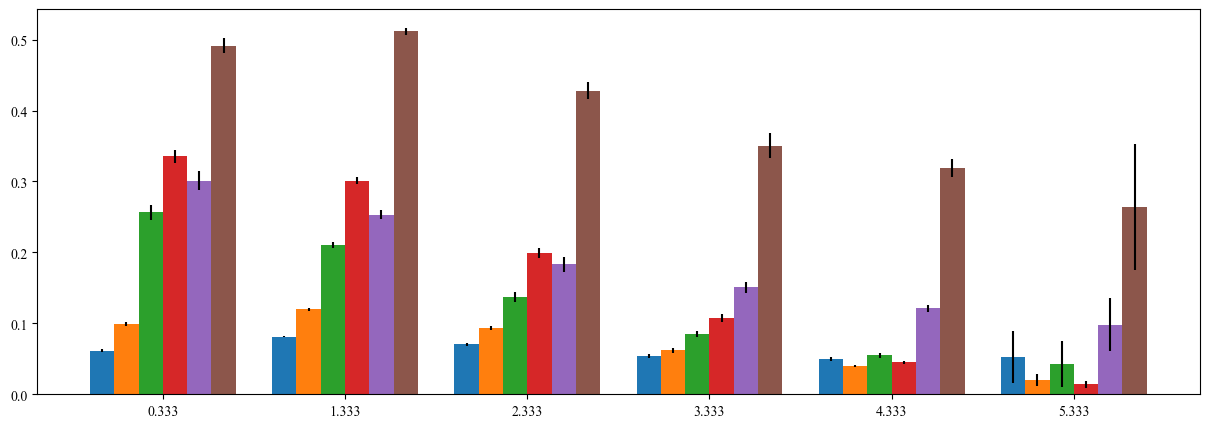

In [139]:
xticklabels = [r'$[0, 3^1)$', r'$[3^1, 3^2)$', r'$[3^2, 3^3)$', r'$[3^3, 3^4)$', r'$[3^4, 3^5)$', r'$[3^5, 3^6)$', r'$[3^6, 3^7)$', r'$[3^7, 3^8)$', r'$[3^8, 3^9)$']
file_name = './fig/' + args.dataset + '/Log_TrainDegree_TestPerformance.png'
unique_val = analyzer.log_deg_perform(keys, test_metrics, train_deg, xticklabels, args, upper_limit = 20000, base = 3, file_name = file_name)
np.unique(unique_val)

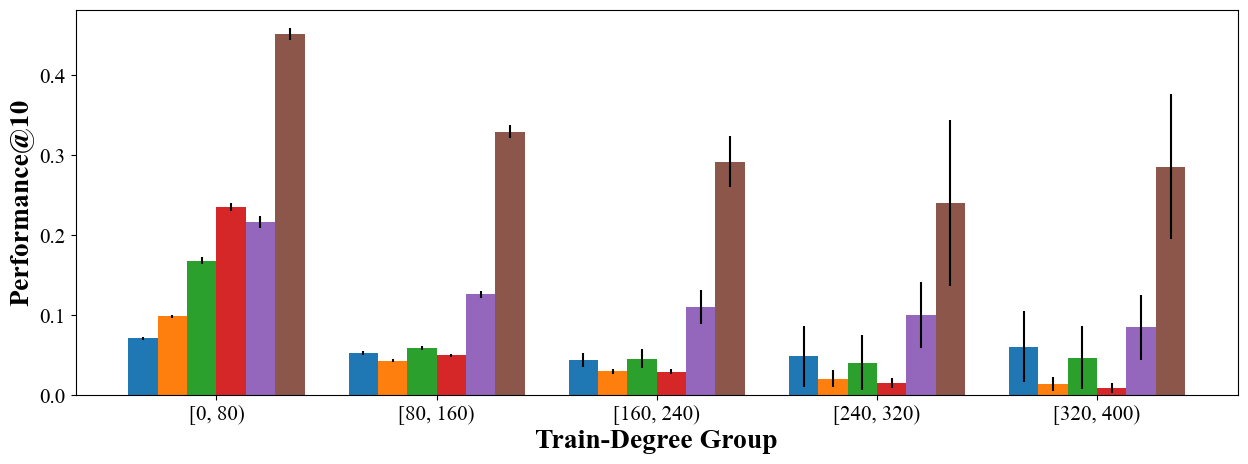

In [424]:
xticklabels = ['[0, 80)', '[80, 160)', '[160, 240)', '[240, 320)', '[320, 400)']
file_name = './fig/' + args.dataset + '/TrainDegree_TestPerformance.png'
unique_val = analyzer.deg_perform(keys, test_metrics, train_deg, xticklabels, args, group_num = 5, interval = 80, upper_limit = 400, file_name = file_name, xlabel = 'Train-Degree Group')

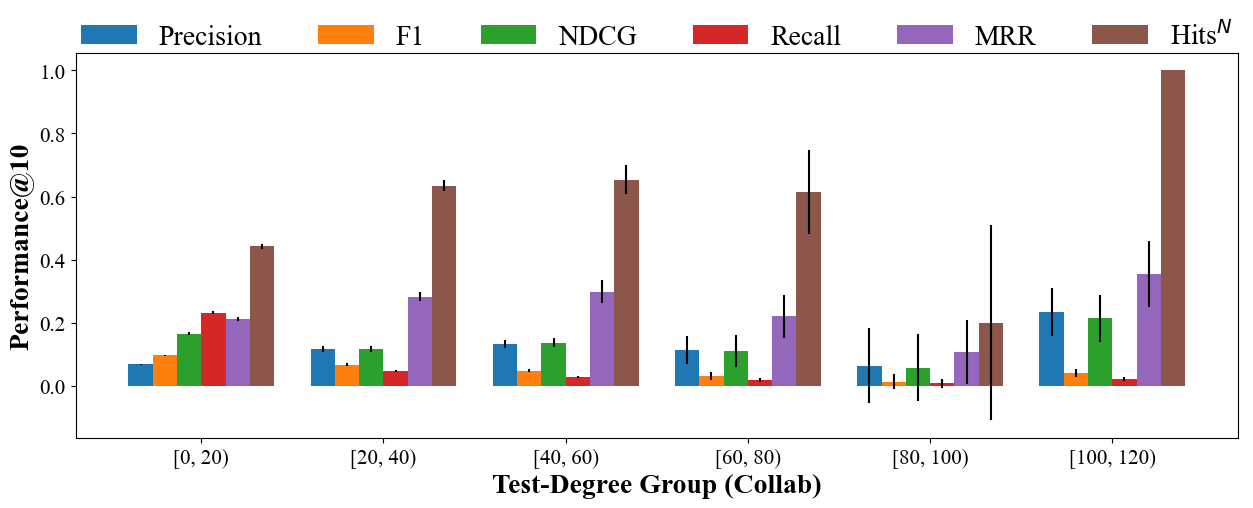

In [142]:
xticklabels = ['[0, 20)', '[20, 40)', '[40, 60)', '[60, 80)', '[80, 100)', '[100, 120)']
file_name = './fig/' + args.dataset + '/GCN_Test_Degree_Test_Performance.png'
xlabel = 'Test-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, test_deg, xticklabels, args, group_num = 6, interval = 20, upper_limit = math.inf, file_name = file_name, xlabel = xlabel)

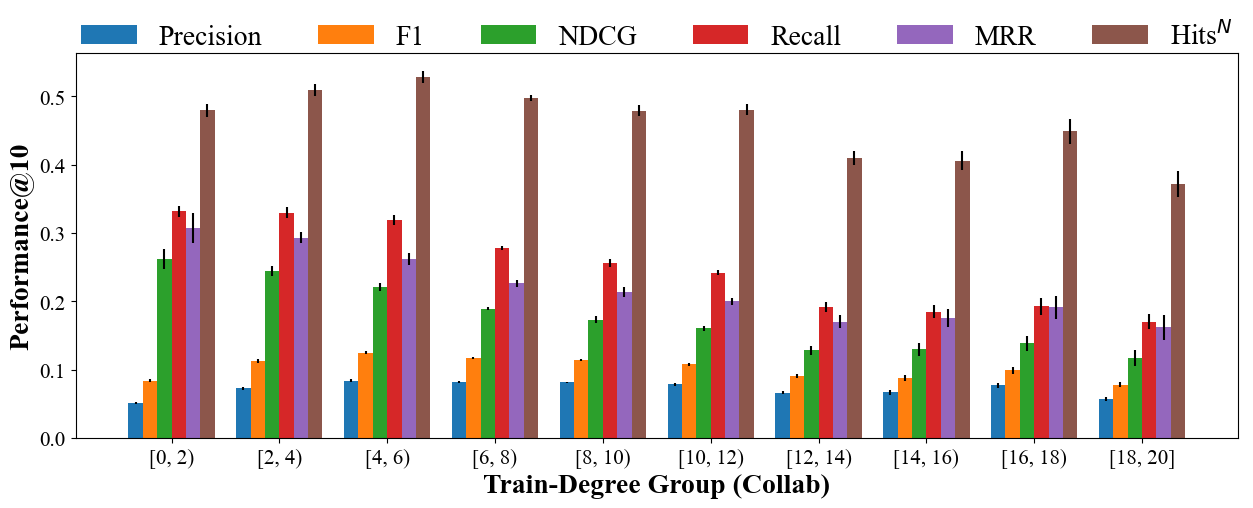

In [143]:
xticklabels = ['[0, 2)', '[2, 4)', '[4, 6)', '[6, 8)', '[8, 10)', '[10, 12)', '[12, 14)', '[14, 16)', '[16, 18)', '[18, 20]']
file_name = './fig/' + args.dataset + '/GCN_Train_Degree_TestPerformance_cold.png'
xlabel = 'Train-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, train_deg, xticklabels, args, group_num = 10, interval = 2, upper_limit = 20, file_name = file_name, xlabel = xlabel)

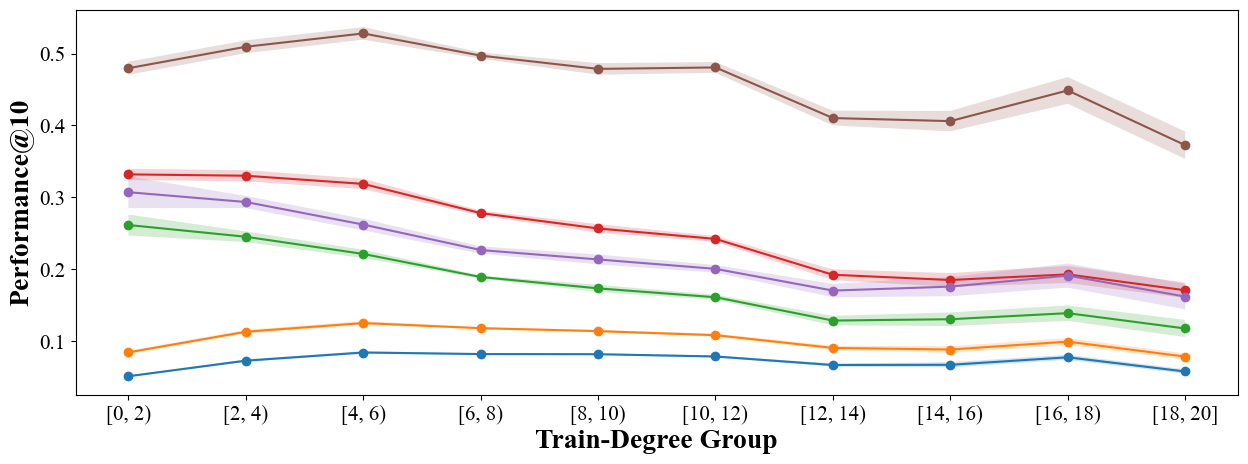

In [423]:
xticklabels = ['[0, 2)', '[2, 4)', '[4, 6)', '[6, 8)', '[8, 10)', '[10, 12)', '[12, 14)', '[14, 16)', '[16, 18)', '[18, 20]']
file_name = './fig/' + args.dataset + '/GCN_Train_Degree_TestPerformance_cold_line.png'
xlabel = 'Train-Degree Group'
analyzer.deg_perform_line(keys, test_metrics, train_deg, xticklabels, args, group_num = 10, interval = 2, upper_limit = 20, file_name = file_name, xlabel = xlabel)

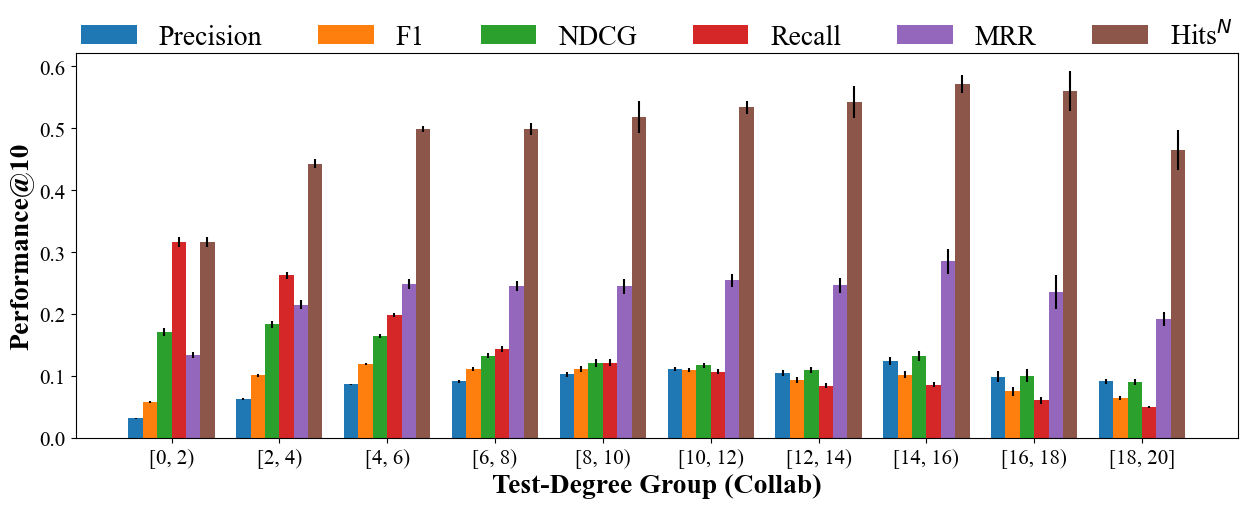

In [144]:
xticklabels = ['[0, 2)', '[2, 4)', '[4, 6)', '[6, 8)', '[8, 10)', '[10, 12)', '[12, 14)', '[14, 16)', '[16, 18)', '[18, 20]']
file_name = './fig/' + args.dataset + '/GCN_Test_Degree_TestPerformance_cold.png'
xlabel = 'Test-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, test_deg, xticklabels, args, group_num = 10, interval = 2, upper_limit = 20, file_name = file_name, xlabel = xlabel)

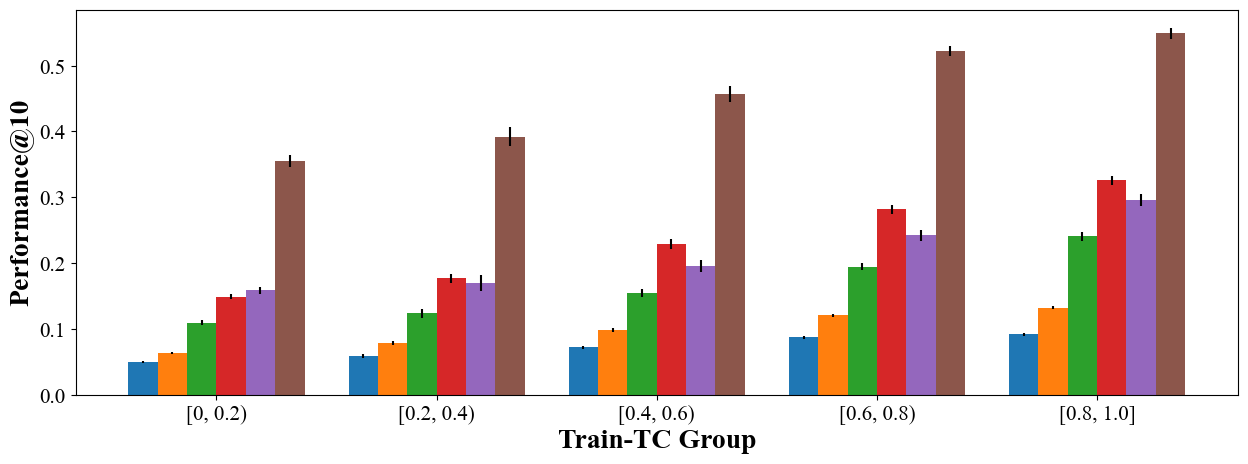

In [426]:
xticklabels = ['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0]']
file_name = './fig/' + args.dataset + '/GCN_Train-TC_TestPerformance.png'
group_num = 5
interval = 0.2
upper_limit = 1
xlabel = 'Train-TC Group'

analyzer.tc_perform(keys, test_metrics, tc_test_node['train'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

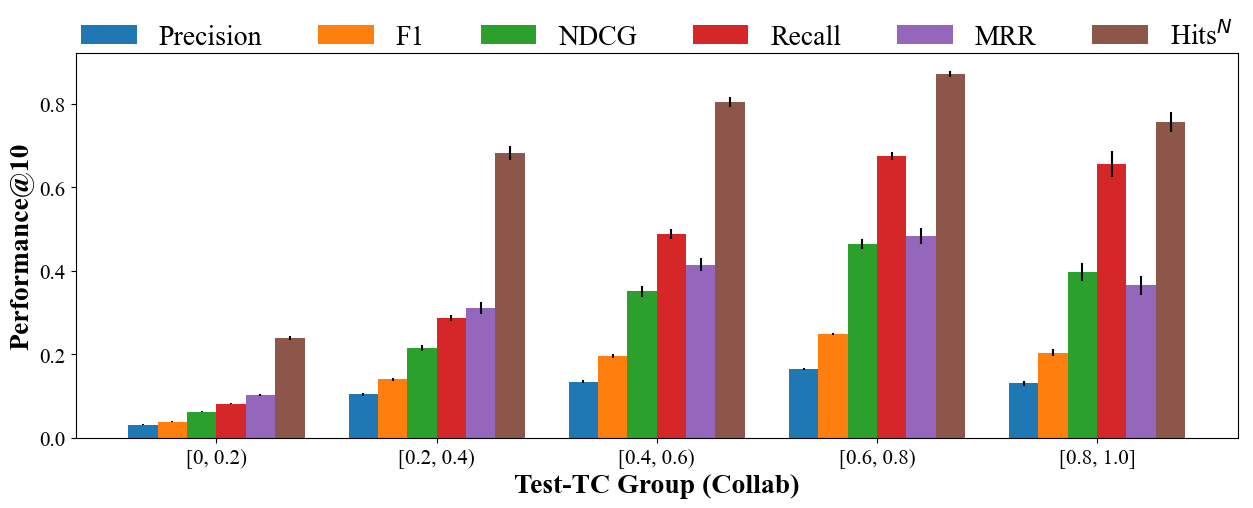

In [146]:
xticklabels = ['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0]']
file_name = './fig/' + args.dataset + '/GCN_Test-TC_TestPerformance.png'
group_num = 5
interval = 0.2
upper_limit = 1
xlabel = 'Test-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['test'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

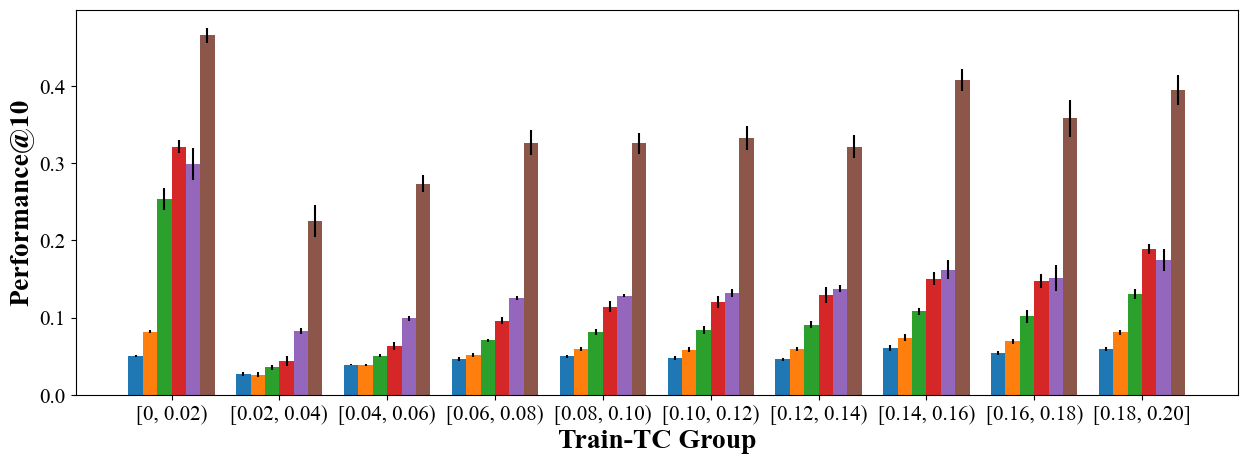

In [427]:
xticklabels = ['[0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)', '[0.08, 0.10)', '[0.10, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 0.18)', '[0.18, 0.20]']
file_name = './fig/' + args.dataset + '/GCN_Train-TC_TestPerformance_cold.png'
group_num = 10
interval = 0.02
upper_limit = 0.2
xlabel = 'Train-TC Group'

analyzer.tc_perform(keys, test_metrics, tc_test_node['train'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

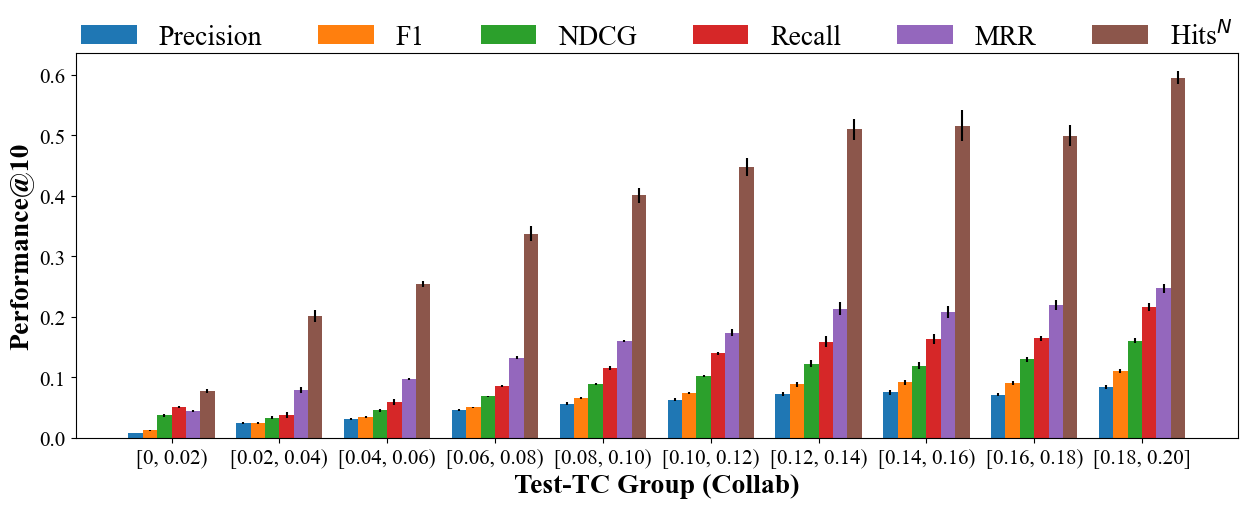

In [148]:
xticklabels = ['[0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)', '[0.08, 0.10)', '[0.10, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 0.18)', '[0.18, 0.20]']
file_name = './fig/' + args.dataset + '/GCN_Test-TC_TestPerformance_cold.png'
group_num = 10
interval = 0.02
upper_limit = 0.2
xlabel = 'Test-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['test'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

In [9]:
train_deg = np.array(args.deg['Train'])[test_node]
val_deg = np.array(args.deg['Val'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]
train_tc = np.array(args.tc['train_train'])[test_node]
val_tc = np.array(args.tc['train_val'])[test_node]
test_tc = np.array(args.tc['train_test'])[test_node]

In [10]:
import pickle as pkl
tc_2 = pkl.load(open('./data/ogbl-collab/tc_2.pkl', 'rb'))
tc_3 = pkl.load(open('./data/ogbl-collab/tc_3.pkl', 'rb'))

train_tc2 = np.array(tc_2['train_train'])[test_node]
val_tc2 = np.array(tc_2['train_val'])[test_node]
test_tc2 = np.array(tc_2['train_test'])[test_node]

train_tc3 = np.array(tc_3['train_train'])[test_node]
val_tc3 = np.array(tc_3['train_val'])[test_node]
test_tc3 = np.array(tc_3['train_test'])[test_node]

In [11]:
import pickle as pkl
density_1 = pkl.load(open('./data/ogbl-collab/density_1.pkl', 'rb'))
density_2 = pkl.load(open('./data/ogbl-collab/density_2.pkl', 'rb'))
density_3 = pkl.load(open('./data/ogbl-collab/density_3.pkl', 'rb'))

density1 = np.array(density_1)[test_node]
density2 = np.array(density_2)[test_node]
density3 = np.array(density_3)[test_node]

## 1. Visualize correlation between each metric and tc
### 1.1. Correlation between train-test tc and each metric

In [217]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.5184360366460066
Precision 10 0.5437197369138154
Precision 20 0.5107501454645275
Precision 50 0.4126860635785902
Precision 100 0.325102193729942
F1 5 0.5857706499706985
F1 10 0.6310529348283666
F1 20 0.5964134426527479
F1 50 0.47994409080353445
F1 100 0.37130568912523965
NDCG 5 0.5442918970247792
NDCG 10 0.6281835514990598
NDCG 20 0.6705532836917455
NDCG 50 0.6901610342066012
NDCG 100 0.6937079120006889
Recall 5 0.564417681534309
Recall 10 0.6752832909747731
Recall 20 0.732407066522978
Recall 50 0.7533280896825003
Recall 100 0.7468963051387979
MRR 0.5084745793451552
Hits$^N$ 5 0.5271556806386704
Hits$^N$ 10 0.5815798574093001
Hits$^N$ 20 0.5924232631546491
Hits$^N$ 50 0.5720254709993949
Hits$^N$ 100 0.548378864184288
Mean correlation: 0.5770941850661985


In [218]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.25737722751382996
Precision 10 0.2832204828942262
Precision 20 0.2788244659792156
Precision 50 0.2387140360476482
Precision 100 0.20134819836750256
F1 5 0.242510243641848
F1 10 0.2901182502494571
F1 20 0.2991033123232227
F1 50 0.264069286523344
F1 100 0.22107518304060797
NDCG 5 0.206646146769437
NDCG 10 0.23303434141657028
NDCG 20 0.2520956958092258
NDCG 50 0.2623819537513628
NDCG 100 0.265215612356003
Recall 5 0.17415737757941605
Recall 10 0.21792158384972693
Recall 20 0.24277560327782566
Recall 50 0.25139196124089774
Recall 100 0.24894522149398404
MRR 0.23503365913510388
Hits$^N$ 5 0.2445340460312344
Hits$^N$ 10 0.2674007368486178
Hits$^N$ 20 0.27189583929032596
Hits$^N$ 50 0.2619569526027244
Hits$^N$ 100 0.24899257041264
Mean correlation: 0.24848999955561532


In [219]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.22518943487285065
Precision 10 0.19254298550025453
Precision 20 0.13528976573059046
Precision 50 0.05782185968482742
Precision 100 0.013058782972432074
F1 5 0.2601084117191203
F1 10 0.23642843227904015
F1 20 0.17325633870260493
F1 50 0.07903883832105324
F1 100 0.022098440645564297
NDCG 5 0.22785598644818145
NDCG 10 0.24272634525670697
NDCG 20 0.23747784695845137
NDCG 50 0.22061182037203345
NDCG 100 0.20877993311449755
Recall 5 0.2296013876382296
Recall 10 0.23581311340209712
Recall 20 0.2156405892790237
Recall 50 0.17541677295542737
Recall 100 0.14435635996198792
MRR 0.20443359171763634
Hits$^N$ 5 0.20571111470646594
Hits$^N$ 10 0.1800428862656928
Hits$^N$ 20 0.13276829324495154
Hits$^N$ 50 0.07168768598707746
Hits$^N$ 100 0.03366017289529869
Mean correlation: 0.16774681502431144


In [220]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 -0.12612943660495232
Precision 10 -0.08294413733292846
Precision 20 0.0006240841176808009
Precision 50 0.1439804872900759
Precision 100 0.24383348686647024
F1 5 -0.19965781003185668
F1 10 -0.16630543588720909
F1 20 -0.08132879113133261
F1 50 0.08118178255308832
F1 100 0.2051336113829279
NDCG 5 -0.18219230837079017
NDCG 10 -0.20166843922755637
NDCG 20 -0.19854574753005053
NDCG 50 -0.17504820613038552
NDCG 100 -0.15291755568718393
Recall 5 -0.21830035150960025
Recall 10 -0.2287783566097305
Recall 20 -0.21183555241855184
Recall 50 -0.1681255452722968
Recall 100 -0.12951755195815862
MRR -0.13487568724786286
Hits$^N$ 5 -0.1394939683117483
Hits$^N$ 10 -0.11636194807094924
Hits$^N$ 20 -0.06579398474715936
Hits$^N$ 50 0.005489803383194956
Hits$^N$ 100 0.046525201942548756
Mean correlation: -0.0866558598670891


In [221]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.004678731087575368
Precision 10 0.04723454809066919
Precision 20 0.11170632749683582
Precision 50 0.21410989480315978
Precision 100 0.29463312938582115
F1 5 -0.08229214321088527
F1 10 -0.0469238994782397
F1 20 0.02002065327079046
F1 50 0.14164323747623772
F1 100 0.24442920554029723
NDCG 5 -0.06075210174700864
NDCG 10 -0.08029604261674204
NDCG 20 -0.08381648188514643
NDCG 50 -0.07364793993600316
NDCG 100 -0.06009420977122894
Recall 5 -0.12025092267288805
Recall 10 -0.12964354618228477
Recall 20 -0.12694785166870384
Recall 50 -0.11000560827537942
Recall 100 -0.09352764922130084
MRR -0.010778273353032674
Hits$^N$ 5 -0.006315503249940552
Hits$^N$ 10 0.01709697776075153
Hits$^N$ 20 0.04807354572069446
Hits$^N$ 50 0.08480804311286087
Hits$^N$ 100 0.09938586815861228
Mean correlation: 0.009327999562904674


In [163]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1075424423255489
Precision 10 0.1833038917057601
Precision 20 0.29241701673042053
Precision 50 0.46165794584166875
Precision 100 0.5802657376720062
F1 5 -0.06693944536589778
F1 10 0.004336906873202827
F1 20 0.12493871948048517
F1 50 0.3375040186198822
F1 100 0.5017288799306049
NDCG 5 -0.03396166827411252
NDCG 10 -0.0723392666211979
NDCG 20 -0.08147379958785284
NDCG 50 -0.06683796745890457
NDCG 100 -0.04470417235069225
Recall 5 -0.1677807122789208
Recall 10 -0.18559321101457255
Recall 20 -0.1870368920887164
Recall 50 -0.17244864756819156
Recall 100 -0.15346191862816863
MRR 0.07265698973701859
Hits$^N$ 5 0.07845261918782381
Hits$^N$ 10 0.11026211262347717
Hits$^N$ 20 0.14066843242841992
Hits$^N$ 50 0.1717698914000503
Hits$^N$ 100 0.18204381716485485
Mean correlation: 0.08142198924938447


In [189]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.21999659198967286
Precision 10 0.16468205691082935
Precision 20 0.08749740732400406
Precision 50 -0.007339027942284448
Precision 100 -0.058833096214320424
F1 5 0.2805571817257181
F1 10 0.22585605381808074
F1 20 0.1353251992318574
F1 50 0.01612525749102531
F1 100 -0.051122281209858
NDCG 5 0.28108800159673064
NDCG 10 0.2891222925252928
NDCG 20 0.2748127421674399
NDCG 50 0.24911670376643005
NDCG 100 0.23182249443073905
Recall 5 0.29110966075270434
Recall 10 0.2782576472190591
Recall 20 0.23990883590856277
Recall 50 0.18340257070955834
Recall 100 0.14124695074967564
MRR 0.23310463890513144
Hits$^N$ 5 0.2265188000977778
Hits$^N$ 10 0.1842314669188638
Hits$^N$ 20 0.11963375968868499
Hits$^N$ 50 0.04234847823523188
Hits$^N$ 100 -0.005515133960288773
Mean correlation: 0.16434443280139688


In [186]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.08867370165576284
Precision 10 0.03480490788716105
Precision 20 -0.024831832796912194
Precision 50 -0.08402853076625251
Precision 100 -0.11375971172239553
F1 5 0.14872214049225516
F1 10 0.08101464496232694
F1 20 0.003918544677980632
F1 50 -0.07588497500231421
F1 100 -0.11470049453489166
NDCG 5 0.15780782609608277
NDCG 10 0.15202271660221645
NDCG 20 0.13054238106822263
NDCG 50 0.10419574720939465
NDCG 100 0.08812002323595478
Recall 5 0.19862311545854666
Recall 10 0.16241551501260584
Recall 20 0.1145165705034434
Recall 50 0.05682367204523539
Recall 100 0.01883734024864049
MRR 0.08330113877355563
Hits$^N$ 5 0.1054822860626527
Hits$^N$ 10 0.06109473805735275
Hits$^N$ 20 0.0049909683045136965
Hits$^N$ 50 -0.05916606052719745
Hits$^N$ 100 -0.09762920924903432
Mean correlation: 0.04715027552903487


In [187]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.015732950026458605
Precision 10 -0.02353303673116931
Precision 20 -0.056383016669833634
Precision 50 -0.083556668084112
Precision 100 -0.09375547849439447
F1 5 0.048220372808926236
F1 10 -0.0023356005744768473
F1 20 -0.04620933212818633
F1 50 -0.08428779926154216
F1 100 -0.09830442334220545
NDCG 5 0.057962679585816156
NDCG 10 0.04504254950530218
NDCG 20 0.02838432435303819
NDCG 50 0.010774292818826133
NDCG 100 0.0005885144487282785
Recall 5 0.08032377159255594
Recall 10 0.04476533003964547
Recall 20 0.01070605951612911
Recall 50 -0.026496609245863452
Recall 100 -0.05008560703860696
MRR 0.010453855564423272
Hits$^N$ 5 0.02104194923004466
Hits$^N$ 10 -0.01367032847133015
Hits$^N$ 20 -0.04949262624650462
Hits$^N$ 50 -0.08956773017557877
Hits$^N$ 100 -0.11397692383143261
Mean correlation: -0.017602251184820866


In [174]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.21805127928500126
Precision 10 0.19321499092318262
Precision 20 0.1414195390956253
Precision 50 0.06711581886839366
Precision 100 0.02198031342527073
F1 5 0.26002299685609415
F1 10 0.239712405326268
F1 20 0.17822424780447257
F1 50 0.08500614831970713
F1 100 0.02783168263357136
NDCG 5 0.22640362532095867
NDCG 10 0.24716609137206225
NDCG 20 0.24302655361422978
NDCG 50 0.22503019685102962
NDCG 100 0.21167877334518803
Recall 5 0.24400274354051654
Recall 10 0.25625076693354215
Recall 20 0.23632396548904672
Recall 50 0.19172941628833592
Recall 100 0.15589934500389097
MRR 0.18434529252409682
Hits$^N$ 5 0.19866274883454121
Hits$^N$ 10 0.17754253590915886
Hits$^N$ 20 0.12930526028769124
Hits$^N$ 50 0.06365799533717392
Hits$^N$ 100 0.02219549955308919
Mean correlation: 0.17099231664392842


In [175]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.23159301248734152
Precision 10 0.2505862941669576
Precision 20 0.24690525726416782
Precision 50 0.21452961995357053
Precision 100 0.183230656159353
F1 5 0.2315575183856594
F1 10 0.26390031203601355
F1 20 0.2673959453912952
F1 50 0.23639965527810416
F1 100 0.1994037044920294
NDCG 5 0.2152202802763657
NDCG 10 0.23949947390393467
NDCG 20 0.25624917032705036
NDCG 50 0.2659508866154253
NDCG 100 0.2685192328897536
Recall 5 0.19654934059537196
Recall 10 0.2319770410885656
Recall 20 0.25299731167588335
Recall 50 0.2613564052438144
Recall 100 0.25829100708277897
MRR 0.22212939766668596
Hits$^N$ 5 0.23311732449736888
Hits$^N$ 10 0.2552140419326658
Hits$^N$ 20 0.2631871717774495
Hits$^N$ 50 0.2586212789936326
Hits$^N$ 100 0.248663227956485
Mean correlation: 0.24050171415914326


In [176]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.4658899234380413
Precision 10 0.48020920562489466
Precision 20 0.44697259821177115
Precision 50 0.358685233468008
Precision 100 0.281671997692473
F1 5 0.5631791038596214
F1 10 0.5805831577463344
F1 20 0.5342419438175343
F1 50 0.42061405842655125
F1 100 0.3222147857955144
NDCG 5 0.569368090628147
NDCG 10 0.6497411787176703
NDCG 20 0.6876430967080256
NDCG 50 0.7049288136872359
NDCG 100 0.7082922855766942
Recall 5 0.6187752510512271
Recall 10 0.7159529149780124
Recall 20 0.7660852684752268
Recall 50 0.7840334084064045
Recall 100 0.7782166006271055
MRR 0.4910027776360703
Hits$^N$ 5 0.5079680719099522
Hits$^N$ 10 0.5650485397540073
Hits$^N$ 20 0.5815446872854527
Hits$^N$ 50 0.5699205971864245
Hits$^N$ 100 0.5535286263466611
Mean correlation: 0.5656273929636562


In [177]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1874794222645224
Precision 10 0.17595622950956194
Precision 20 0.14282721429211087
Precision 50 0.0912768822574831
Precision 100 0.057719283708358764
F1 5 0.22310532710204287
F1 10 0.211678251273922
F1 20 0.16735761285049233
F1 50 0.09977092174901742
F1 100 0.05787210183056125
NDCG 5 0.19982745478301234
NDCG 10 0.2207781229145929
NDCG 20 0.2186190287238958
NDCG 50 0.20425619728650513
NDCG 100 0.19326399266163913
Recall 5 0.21937910761127807
Recall 10 0.2342479695957154
Recall 20 0.21798558564418952
Recall 50 0.17878710849192261
Recall 100 0.14624390076095425
MRR 0.15611266228231402
Hits$^N$ 5 0.17126162438477985
Hits$^N$ 10 0.15588554332338012
Hits$^N$ 20 0.1136493183924544
Hits$^N$ 50 0.05416933964066337
Hits$^N$ 100 0.01608198884292177
Mean correlation: 0.15829200739147276


In [178]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.22282740965041764
Precision 10 0.24580593940307735
Precision 20 0.24764707728488974
Precision 50 0.22452320140346158
Precision 100 0.20005185469296907
F1 5 0.22027250204292206
F1 10 0.25465218984925997
F1 20 0.26198643232905555
F1 50 0.24057911682854471
F1 100 0.21176408674349145
NDCG 5 0.20577314239643937
NDCG 10 0.23013682998172785
NDCG 20 0.2464320210449965
NDCG 50 0.2566043319285674
NDCG 100 0.2598125445835532
Recall 5 0.1882772334022453
Recall 10 0.22416995673050613
Recall 20 0.24432423564171118
Recall 50 0.25322414994849046
Recall 100 0.25061584090940686
MRR 0.20846772593640828
Hits$^N$ 5 0.2208653629472186
Hits$^N$ 10 0.24268779209714783
Hits$^N$ 20 0.2503419256374507
Hits$^N$ 50 0.24632649734236098
Hits$^N$ 100 0.23688821394399967
Mean correlation: 0.23442529287308922


In [179]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.431623125689993
Precision 10 0.4544920287252469
Precision 20 0.4328146121213714
Precision 50 0.36123949893658525
Precision 100 0.29536109156282414
F1 5 0.5177672176388968
F1 10 0.5421424387931436
F1 20 0.5071166686476049
F1 50 0.4131929387217055
F1 100 0.3295110855931367
NDCG 5 0.5238475163994751
NDCG 10 0.6012575653553389
NDCG 20 0.6375356955521987
NDCG 50 0.6546124618895081
NDCG 100 0.6588095978771592
Recall 5 0.5718494709042754
Recall 10 0.6677877452154787
Recall 20 0.7150155512371572
Recall 50 0.7311611999465322
Recall 100 0.7260353537514489
MRR 0.45005946529792074
Hits$^N$ 5 0.46853309318854447
Hits$^N$ 10 0.5257197397305766
Hits$^N$ 20 0.5407521175661573
Hits$^N$ 50 0.5293288540491451
Hits$^N$ 100 0.514457119501351
Mean correlation: 0.5308470482266453


In [26]:
res = {
    "Train-TC": {
        "Precision": [0.2252, 0.1925, 0.1353, 0.0578],
        "F1": [0.2601, 0.2364, 0.1733, 0.0790],
        "NDCG": [0.2279, 0.2427, 0.2375, 0.2206],
        "Recall": [0.2296, 0.2358, 0.2156, 0.1754],
        "Hits^N": [0.2057, 0.1800, 0.1328, 0.0717],
        "MRR": [0.2044, 0.2044, 0.2044, 0.2044],
    },
    "Val-TC": {
        "Precision": [0.2573, 0.2832, 0.2788, 0.2387],
        "F1": [0.2425, 0.2901, 0.2991, 0.2641],
        "NDCG": [0.2066, 0.2330, 0.2521, 0.2624],
        "Recall": [0.1742, 0.2179, 0.2428, 0.2514],
        "Hits^N": [0.2445, 0.2674, 0.2720, 0.2620],
        "MRR": [0.2350, 0.2350, 0.2350, 0.2350],
    },
    "Test-TC": {
        "Precision": [0.5184, 0.5437, 0.5107, 0.4127],
        "F1": [0.5858, 0.6311, 0.5964, 0.4799],
        "NDCG": [0.5443, 0.6282, 0.6706, 0.6902],
        "Recall": [0.5644, 0.6753, 0.7324, 0.7533],
        "Hits^N": [0.5272, 0.5816, 0.5924, 0.5720],
        "MRR": [0.5085, 0.5085, 0.5085, 0.5085],
    },
    "Train Degree": {
        "Precision": [-0.1261, -0.0829, 0.0006, 0.1440],
        "F1": [-0.1997, -0.1663, -0.0813, 0.0812],
        "NDCG": [-0.1822, -0.2017, -0.1985, -0.1750],
        "Recall": [-0.2183, -0.2288, -0.2118, -0.1681],
        "Hits^N": [-0.1395, -0.1164, -0.0658, 0.0055],
        "MRR": [-0.1349, -0.1349, -0.1349, -0.1349],
    },
    "Val Degree": {
        "Precision": [0.0047, 0.0472, 0.1117, 0.2141],
        "F1": [-0.0823, -0.0469, 0.0200, 0.1416],
        "NDCG": [-0.0608, -0.0803, -0.0838, -0.0736],
        "Recall": [-0.1203, -0.1296, -0.1269, -0.1100],
        "Hits^N": [-0.0063, 0.0171, 0.0481, 0.0848],
        "MRR": [-0.0108, -0.0108, -0.0108, -0.0108],
    },
    "Test Degree": {
        "Precision": [0.1075, 0.1833, 0.2924, 0.4617],
        "F1": [-0.0669, 0.0043, 0.1249, 0.3375],
        "NDCG": [-0.0340, -0.0723, -0.0814, -0.0668],
        "Recall": [-0.1678, -0.1856, -0.1870, -0.1724],
        "Hits^N": [0.0785, 0.1103, 0.1407, 0.1718],
        "MRR": [0.0727, 0.0727, 0.0727, 0.0727],
    },
    "Density": {
        "Precision": [0.2199, 0.1646, 0.0875, -0.0073],
        "F1": [0.2806, 0.2259, 0.1353, 0.0161],
        "NDCG": [0.2811, 0.2891, 0.2748, 0.2491],
        "Recall": [0.2911, 0.2783, 0.2399, 0.1834],
        "Hits^N": [0.2265, 0.1842, 0.1196, 0.0423],
        "MRR": [0.2331, 0.2331, 0.2331, 0.2331],
    },
}

In [32]:
def cal_abs_avg(vals):
    return sum([abs(v) for v in vals]) / len(vals)

def cal_avg(vals):
    return sum(vals) / len(vals)

topo_res = {}
for topo_metric in res:
    abs_avgs = []
    avgs = []
    for eval_metric in res[topo_metric]:
        vals = [k for k in res[topo_metric][eval_metric]]
        
        abs_avg = cal_abs_avg(vals)
        avg = cal_avg(vals)

        # print(topo_metric, eval_metric, abs_avg, avg)

        abs_avgs.append(abs_avg)
        avgs.append(abs_avg)

    topo_res[topo_metric] = [abs_avgs, avgs]

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

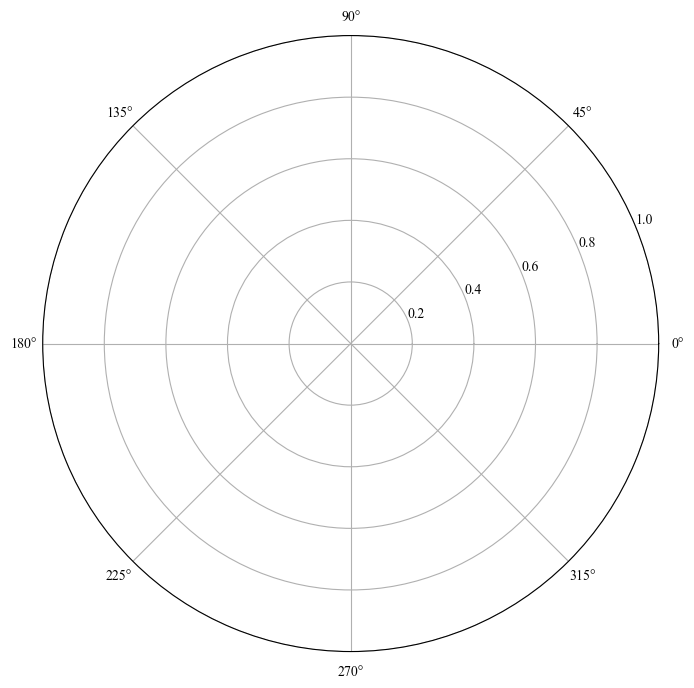

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
labels = ['Precision', 'F1', 'NDCG', 'Recall', r'Hits$^N$', 'MRR']

# Setup plot
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by adding the first angle at the end of the list
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Helper function to plot data on radar chart
def add_to_radar(angles, data, label_name, color):
    data += data[:1]  # Add the first data point at the end to close the loop
    # ax.fill(angles, data, color=color, alpha=0.25)
    ax.plot(angles, data, label=label_name, color=color)

# Plot each data series
add_to_radar(angles, topo_res['Train-TC'][1], 'Train-TC', 'navy')
add_to_radar(angles, topo_res['Val-TC'][1], 'Val-TC', 'cornflowerblue')
add_to_radar(angles, topo_res['Train Degree'][1], 'Train-Degree', 'saddlebrown')
add_to_radar(angles, topo_res['Val Degree'][1], 'Val-Deg', 'sandybrown')
add_to_radar(angles, topo_res['Density'][1], 'Density', 'red')

# Add labels to plot
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize = 20, fontweight = 'bold')

# Add legend
# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize = 15, frameon = 0)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon = 0, fontsize = 15)

# Show plot
plt.savefig(f'./fig/{args.dataset}/Radar_correlation_all.png', transparent = True, dpi = 200, bbox_inches = 'tight')

In [13]:
train_deg = np.array(args.deg['Train'])[test_node]
val_deg = np.array(args.deg['Val'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]
train_tc = np.array(args.tc['train_train'])[test_node]
val_tc = np.array(args.tc['train_val'])[test_node]
test_tc = np.array(args.tc['train_test'])[test_node]

In [17]:
np.arange(0, 11, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

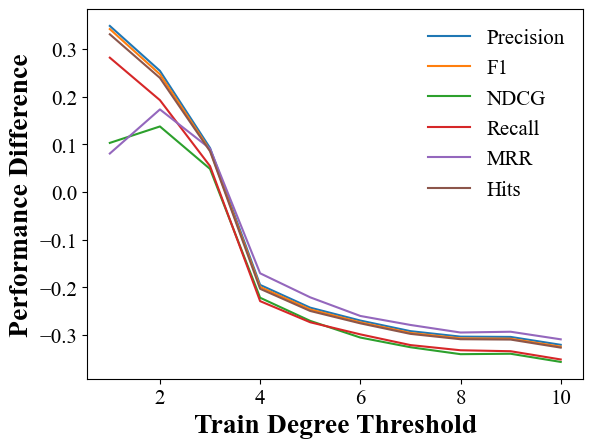

In [52]:
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        ratio = []
        
        for k in range(metric.shape[2]):
            ratio.append([])
            tmp = metric.mean(axis = 0)[:, k]
            for interval in np.arange(1, 11, 1):
                val1 = tmp[train_deg <= interval].mean()
                val2 = tmp[train_deg > interval] .mean()
                ratio[-1].append((val2 - val1)/val1)

        # print(np.array(ratio).mean(axis = 0))
        plt.plot(range(1, 11, 1), np.array(ratio).mean(axis = 0), label = key)
    else:
        ratio = []

        tmp = metric.mean(axis = 0)
        for interval in np.arange(1, 11, 1):
            val1 = tmp[train_deg <= interval].mean()
            val2 = tmp[train_deg > interval] .mean()
            ratio.append((val2 - val1)/val1)

        plt.plot(range(1, 11, 1), np.array(ratio), label = key)
    
        
plt.xlabel('Train Degree Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon = 0, fontsize = 15)

(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

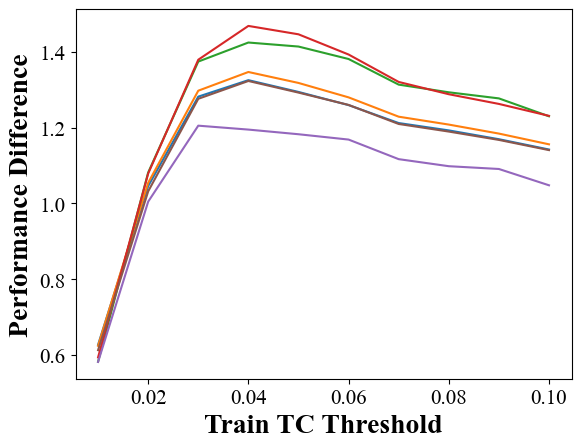

In [57]:
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        ratio = []
        
        for k in range(metric.shape[2]):
            ratio.append([])
            tmp = metric.mean(axis = 0)[:, k]
            for interval in np.arange(0.01, 0.11, 0.01):
                val1 = tmp[train_tc <= interval].mean()
                val2 = tmp[train_tc > interval] .mean()
                ratio[-1].append((val2 - val1)/val1)

        plt.plot(np.arange(0.01, 0.11, 0.01), np.array(ratio).mean(axis = 0), label = key)
    else:
        ratio = []

        tmp = metric.mean(axis = 0)
        for interval in np.arange(0.01, 0.11, 0.01):
            val1 = tmp[train_tc <= interval].mean()
            val2 = tmp[train_tc > interval] .mean()
            ratio.append((val2 - val1)/val1)

        plt.plot(np.arange(0.01, 0.11, 0.01), np.array(ratio), label = key)

plt.xlabel('Train TC Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(frameon = 0, fontsize = 15)

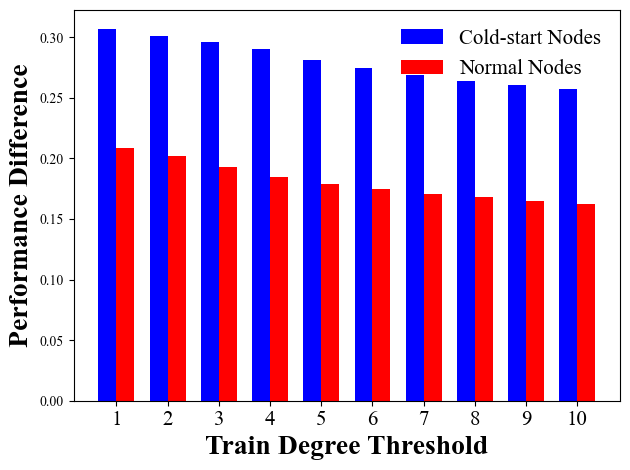

In [277]:
key = 'MRR'
metric = test_metrics[keys.index(key)]

val1s, val2s = [], []
tmp = metric.mean(axis = 0)
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval] .mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35  # Width of the bars
index = np.arange(len(intervals))

bar1 = plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='b')
bar2 = plt.bar(index + bar_width, val2s, bar_width, label='Normal Nodes', color='r')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Train Degree Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(index + bar_width / 2, intervals, fontsize = 15)  # Position of tick labels
plt.legend(frameon = 0, fontsize = 15)

plt.tight_layout()

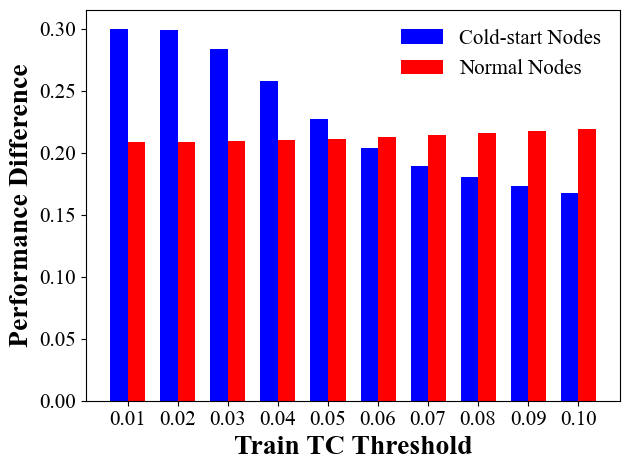

In [278]:
key = 'MRR'
metric = test_metrics[keys.index(key)]

val1s, val2s = [], []
tmp = metric.mean(axis = 0)
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

intervals = np.arange(0.01, 0.11, 0.01)
bar_width = 0.35  # Width of the bars
index = np.arange(len(intervals))

bar1 = plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='b')
bar2 = plt.bar(index + bar_width, val2s, bar_width, label='Normal Nodes', color='r')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Train TC Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(index + bar_width / 2, ["{:.2f}".format(i) for i in intervals], fontsize=15)
plt.yticks(fontsize = 15)
plt.legend(frameon = 0, fontsize = 15)

plt.tight_layout()

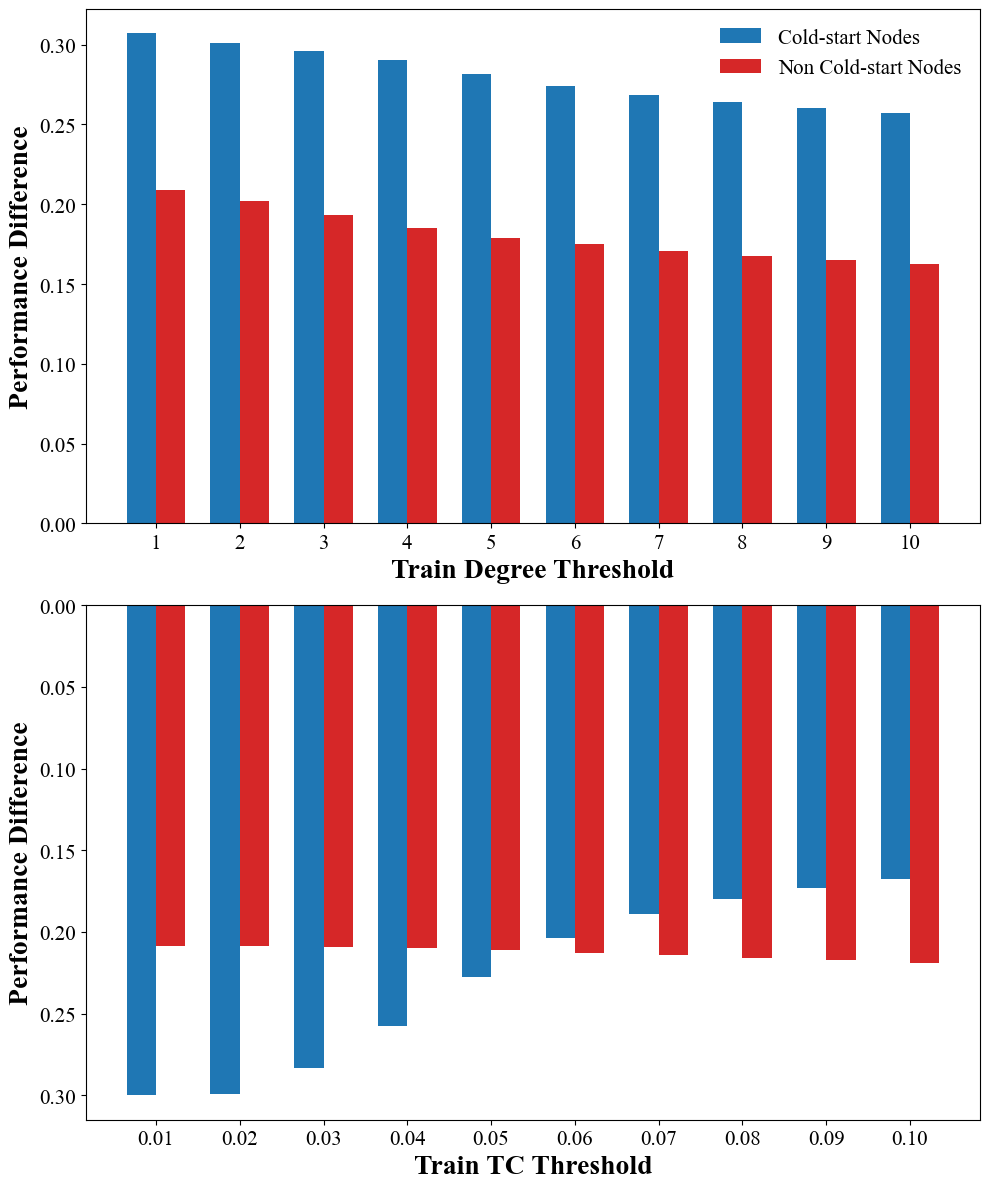

In [279]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# First subplot
plt.subplot(2, 1, 1)

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval].mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35
index = np.arange(len(intervals))

plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
plt.bar(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

plt.xlabel('Train Degree Threshold', fontsize=20, fontweight='bold')
plt.ylabel('Performance Difference', fontsize=20, fontweight='bold')
plt.xticks(index + bar_width / 2, intervals, fontsize=15)
plt.legend(frameon=0, fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

# Second subplot
plt.subplot(2, 1, 2)

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

intervals = np.arange(0.01, 0.11, 0.01)
bar_width = 0.35
index = np.arange(len(intervals))

plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
plt.bar(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

plt.xlabel('Train TC Threshold', fontsize=20, fontweight='bold')
plt.ylabel('Performance Difference', fontsize=20, fontweight='bold')
plt.xticks(index + bar_width / 2, ["{:.2f}".format(i) for i in intervals], fontsize=15)
plt.yticks(fontsize=15)

plt.gca().invert_yaxis()  # Invert y-axis

plt.tight_layout()
plt.savefig('./fig/ogbl-collab/cold_start.png', transparent = True, dpi = 200, bbox_inches = 'tight')

/tmp/ipykernel_4171621/4215234413.py:9: RuntimeWarning: divide by zero encountered in log2
  v = np.log2(v)


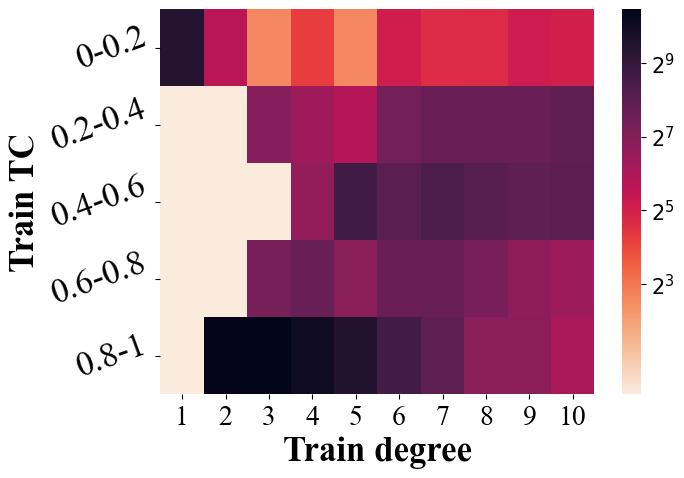

In [280]:
f, ax3 = plt.subplots(1, 1, figsize = (7, 5))

yticklabels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']

xticklabels = ['[0, 50)', '[50, 100)', '[100, 150)', '[150, 200)', '[200, 250)', '[250, 300)', '[300, 350)', '[350, Inf)']
xticklabels_colder = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

v = ratio_group_by_deg_lcc(train_deg, train_tc, 10, 1, 10)
v = np.log2(v)
mask = np.isinf(v)
v[mask] = np.mean(v[~mask])
v_min, v_max = np.min(v), np.max(v)
v[mask] = 0
ax3 = sns.heatmap(v, xticklabels = xticklabels_colder, yticklabels = yticklabels, ax = ax3, cmap="rocket_r")
ax3.set_xticklabels(xticklabels_colder, rotation = 0, fontsize = 20)
ax3.set_yticklabels(yticklabels, rotation = 20, fontsize = 25)
ax3.set_xlabel('Train degree', fontsize = 25, fontweight = 'bold')
ax3.set_ylabel('Train TC', fontsize = 25, fontweight = 'bold')
ax3.collections[0].colorbar.ax.tick_params(labelsize=25)

cbar = ax3.collections[0].colorbar
cbar_ticks = np.arange(int(v_min) + 1, int(v_max) + 1, 2)  # Update this range based on your requirements
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'$2^{{{t}}}$' for t in cbar_ticks])  # Format tick labels as powers of 2
cbar.ax.tick_params(labelsize=15)

plt.savefig(f'./fig/{args.dataset}/Train_deg_vs_Train_TC_cold.png', dpi = 200, bbox_inches='tight', transparent = True)

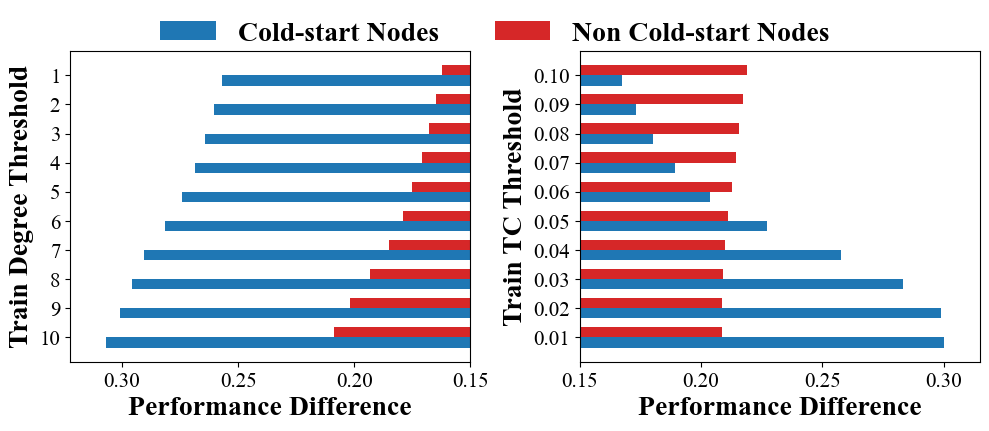

In [367]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot (on the left)
# First subplot (on the left)
ax = axs[0]

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval].mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35
index = np.arange(len(intervals))

# Reflecting the bars
ax.barh(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
ax.barh(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

ax.set_ylabel('Train Degree Threshold', fontsize=20, fontweight='bold')
ax.set_xlabel('Performance Difference', fontsize=20, fontweight='bold')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(reversed(intervals), fontsize=15)  # Reverse the tick labels
ax.tick_params(axis='x', labelsize=15)

# Ensure the bars span from right to left
ax.invert_xaxis()
ax.set_xlim([None, 0.15])  # Here's where we set the x-axis to start at 0.15


# Second subplot (on the right)
ax = axs[1]

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

intervals = np.arange(0.01, 0.11, 0.01)
bar_width = 0.35
index = np.arange(len(intervals))

ax.barh(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
ax.barh(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

ax.set_ylabel('Train TC Threshold', fontsize=20, fontweight='bold')
ax.set_xlabel('Performance Difference', fontsize=20, fontweight='bold')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(["{:.2f}".format(i) for i in intervals], fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlim([0.15, None]) 
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', frameon=0, fontsize=15, ncol=2, bbox_to_anchor=(0.5, 1.1), prop={'size': 20, 'weight':'bold'})

plt.tight_layout()
plt.savefig(f'./fig/{args.dataset}/cold_diff.png', transparent=True, dpi=200, bbox_inches='tight')

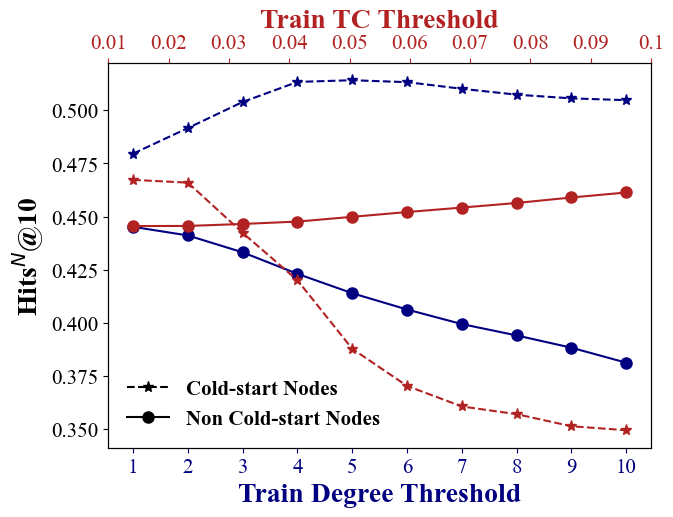

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with horizontal subplots
fig, axs = plt.subplots(1, 1, figsize=(7, 5))

ax = axs

key = r'Hits$^N$'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)[:, 1]
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval].mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35
index = np.arange(len(intervals))

ax.plot(index, val1s, label='Cold-start Nodes', color='navy', linestyle = '--', marker = '*', markersize = 8)
ax.plot(index, val2s, label='Non Cold-start Nodes', color='navy', linestyle = '-', marker = 'o', markersize = 8)

ax.set_xticks(index)
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_xlabel('Train Degree Threshold', fontsize=20, fontweight='bold', color = 'navy')
ax.set_ylabel(r'Hits$^N$@10', fontsize=20, fontweight='bold')
ax.tick_params(axis='x', labelsize=15, colors='navy')  # Set tick color for lower x-axis
ax.tick_params(axis='y', labelsize=15)
legend = ax.legend(loc='lower left', ncol=1, frameon = 0, fontsize = 20, prop = {'weight':'bold', 'size': 15})
for text in legend.get_texts():
    text.set_color("black")

for handle in legend.legendHandles:
    handle.set_color("black")
    # handle.set_edgecolor("black")

# Create a secondary x-axis
ax2 = ax.twiny()

key = r'Hits$^N$'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)[:, 1]
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

ax2.set_xticks(index)
ax2.set_xticklabels(np.arange(0.01, 0.11, 0.01).round(2))
ax2.set_xlabel('Train TC Threshold', fontsize=20, fontweight='bold', color = 'firebrick')
ax2.tick_params(axis='x', labelsize=15, colors='firebrick')  # Set tick color for upper x-axis

ax.plot(index, val1s, label='Cold-start Nodes', color='firebrick', linestyle = '--', marker = '*', markersize = 8)
ax.plot(index, val2s, label='Non Cold-start Nodes', color='firebrick', linestyle = '-', marker = 'o', markersize = 8)


plt.savefig(f'./fig/{args.dataset}/cold_diff_line_hits10.png', transparent=True, dpi=200, bbox_inches='tight')

/tmp/ipykernel_4171621/4039747890.py:9: RuntimeWarning: divide by zero encountered in log2
  v = np.log2(v)


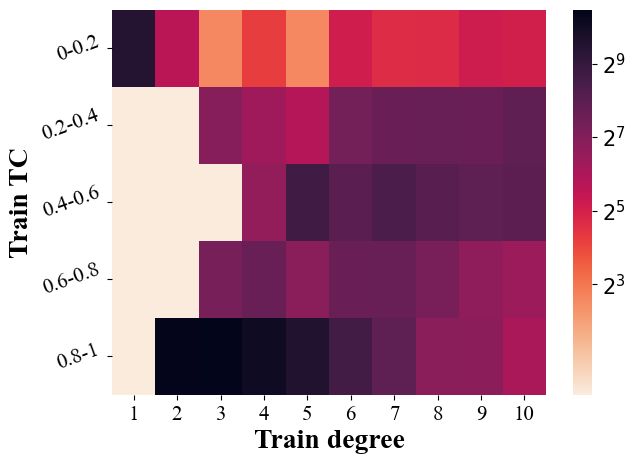

In [413]:
f, ax3 = plt.subplots(1, 1, figsize = (7, 5))

yticklabels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']

xticklabels = ['[0, 50)', '[50, 100)', '[100, 150)', '[150, 200)', '[200, 250)', '[250, 300)', '[300, 350)', '[350, Inf)']
xticklabels_colder = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

v = ratio_group_by_deg_lcc(train_deg, train_tc, 10, 1, 10)
v = np.log2(v)
mask = np.isinf(v)
v[mask] = np.mean(v[~mask])
v_min, v_max = np.min(v), np.max(v)
v[mask] = 0
ax3 = sns.heatmap(v, xticklabels = xticklabels_colder, yticklabels = yticklabels, ax = ax3, cmap="rocket_r")
ax3.set_xticklabels(xticklabels_colder, rotation = 0, fontsize = 15)
ax3.set_yticklabels(yticklabels, rotation = 20, fontsize = 15)
ax3.set_xlabel('Train degree', fontsize = 20, fontweight = 'bold')
ax3.set_ylabel('Train TC', fontsize = 20, fontweight = 'bold')
ax3.collections[0].colorbar.ax.tick_params(labelsize=15)

cbar = ax3.collections[0].colorbar
cbar_ticks = np.arange(int(v_min) + 1, int(v_max) + 1, 2)  # Update this range based on your requirements
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'$2^{{{t}}}$' for t in cbar_ticks])  # Format tick labels as powers of 2
cbar.ax.tick_params(labelsize=15)

plt.savefig(f'./fig/{args.dataset}/Train_deg_vs_Train_TC_cold.png', dpi = 200, bbox_inches='tight', transparent = True)